In [130]:
import os
import joblib
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import r2_score

# Research Questions

- Strip outliers? Aux only, or Aux + labels
- Types of regularization RobustScaler vs MinMaxScaler
- Augment data 
- Aux Data
- Image transformations ( Flip, rotate, blur, colorshift)
- Freezing Layers vs not
- resnet weights
- Which pretrained model to use (Inception-Resnet-V2, Xception, MobileNetV2)
- 6 models vs 1 model
- Aux 6 vs 163 aux data
- Multiple Heads
- Avgpool
- Eval mode model.eval()
- Seperate ensembles for aux data


In [131]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("Using GPU (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS (for macOS with Apple Silicon)
    print("Using MPS (Metal Performance Shaders)")
else:
    device = torch.device("cpu")  # Use CPU
    print("Using CPU")

assert(device is not None)

Using MPS (Metal Performance Shaders)


In [224]:
VERSION = "5"
SUBVERSION="v2"
METADATA_PATH = "./metadata"
AUXSCALER_PATH = f"{METADATA_PATH}/auxScaler{VERSION}.pkl"
LABELSCALER_PATH = f"{METADATA_PATH}/labelScaler{VERSION}.pkl"
MODEL_PATH = f"{METADATA_PATH}/model{VERSION}.pth"
FIG_PATH = f"{METADATA_PATH}/fig{VERSION}.png"
SUBMISSION_PATH = f"{METADATA_PATH}/submission{VERSION}{SUBVERSION}.csv"
TRAIN_AUX_PATH = "./data-3/train.csv"
TRAIN_IMAGE_PATH = "./data-3/train_images"
TEST_AUX_PATH = "./data-3/test.csv"
TEST_IMAGE_PATH = "./data-3/test_images"

TRAIN_DATA_RATIO = 0.8

# print(*zip(range(500),df.columns),sep="\n")
AUX_START = 1
# 1-6 for WORLDCLIM
# 7-67 for SOIL
# 68-127 for MODIS 
# 128-163 for VOD
AUX_END = 163 # 7
AUX_CATEGORIES = AUX_END - AUX_START 

# Labels 
# (164, 'X4_mean')
# (165, 'X11_mean')
# (166, 'X18_mean')
# (167, 'X26_mean')
# (168, 'X50_mean')
# (169, 'X3112_mean')

LABLES_START = 164
LABELS_END = 170
LABELS_CATEGORIES = LABELS_END - LABLES_START

BATCH_SIZE = 100

In [133]:
def loadImages(IMAGE_PATH):
    filenames = [(f.split('.jpeg')[0], f) for f in os.listdir(IMAGE_PATH) if f.endswith('.jpeg')]
    imageMap = { i: Image.open(os.path.join(IMAGE_PATH, p)).convert("RGB") for i, p in filenames }
    return imageMap

trainImgIdMap = loadImages(TRAIN_IMAGE_PATH)
testImgIdMap = loadImages(TEST_IMAGE_PATH)

In [218]:
auxScaler = MinMaxScaler((0,1))
labelScaler = MinMaxScaler((0,1))

image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



class PlantDataset(Dataset):
    def __init__(self, X_ids, X_aux, Y, imgMap, transform):
        self.X_ids = torch.tensor(X_ids)
        self.X_aux = torch.tensor(X_aux, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.imgIdMap = imgMap
        self.transform = transform

    def __len__(self):
        return len(self.X_ids)

    def __getitem__(self, idx):
        x_id = self.X_ids[idx].item()
        x_img = self.imgIdMap[str(x_id)]
        x_img = self.transform(x_img)
        x_aux = self.X_aux[idx]
        y = self.Y[idx]
        return x_id, x_img, x_aux, y

def findOutliers(df):
    zdf = np.abs((df - df.mean())/ df.std())
    outlier_criteria = zdf < 3
    return outlier_criteria.all(axis=1)

def preprocessData(filename, handleOutliers=True):
    # Load Data
    df = pd.read_csv(filename)

    if handleOutliers:
        # Remove Outliers
        previousCount = df.shape[0]
        outlierCheckData = df.iloc[:, AUX_START:LABELS_END] # AUX_END, or LABELS_END?
        outliers = findOutliers(outlierCheckData)
        df = df[outliers]
        currentCount = df.shape[0]
        print(f"Removed {-currentCount + previousCount} Outliers! ({previousCount} to {currentCount})")

    imageIds = df[['id']].values.squeeze()
    auxData = df.iloc[:, AUX_START:AUX_END]
    labels = df.iloc[:, LABLES_START:LABELS_END]

    return imageIds, auxData, labels


In [135]:
imageIds, auxData, labels = preprocessData(TRAIN_AUX_PATH, True)
auxData = auxScaler.fit_transform(auxData)
labels = labelScaler.fit_transform(labels)

joblib.dump(auxScaler, AUXSCALER_PATH)
joblib.dump(labelScaler, LABELSCALER_PATH)

dataset = PlantDataset(imageIds, auxData, labels, trainImgIdMap, image_transform)
train_size = int(TRAIN_DATA_RATIO * len(dataset))
valid_size =  len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)


Removed 12522 Outliers! (43363 to 30841)


In [136]:
class PlantModel(nn.Module):
    def __init__(self):
        super(PlantModel, self).__init__()
        self.aux_branch = nn.Sequential(
            nn.Linear(AUX_CATEGORIES, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32, 6),
        )
    
    def forward(self, img, aux):

        aux_x = self.aux_branch(aux)

        x = aux_x

        return x

TEpoch 1/15, Loss: 0.0328, R2 Score: -0.08%
VEpoch 1/15, Loss: 0.0275, R2 Score: 0.08%
TEpoch 2/15, Loss: 0.0270, R2 Score: 0.11%
VEpoch 2/15, Loss: 0.0270, R2 Score: 0.10%
TEpoch 3/15, Loss: 0.0266, R2 Score: 0.12%
VEpoch 3/15, Loss: 0.0265, R2 Score: 0.11%
TEpoch 4/15, Loss: 0.0264, R2 Score: 0.13%
VEpoch 4/15, Loss: 0.0264, R2 Score: 0.12%
TEpoch 5/15, Loss: 0.0262, R2 Score: 0.13%
VEpoch 5/15, Loss: 0.0264, R2 Score: 0.12%
TEpoch 6/15, Loss: 0.0261, R2 Score: 0.13%
VEpoch 6/15, Loss: 0.0261, R2 Score: 0.13%
TEpoch 7/15, Loss: 0.0261, R2 Score: 0.14%
VEpoch 7/15, Loss: 0.0260, R2 Score: 0.13%
TEpoch 8/15, Loss: 0.0260, R2 Score: 0.14%
VEpoch 8/15, Loss: 0.0259, R2 Score: 0.13%
TEpoch 9/15, Loss: 0.0260, R2 Score: 0.14%
VEpoch 9/15, Loss: 0.0258, R2 Score: 0.14%
TEpoch 10/15, Loss: 0.0259, R2 Score: 0.14%
VEpoch 10/15, Loss: 0.0258, R2 Score: 0.14%
TEpoch 11/15, Loss: 0.0259, R2 Score: 0.14%
VEpoch 11/15, Loss: 0.0259, R2 Score: 0.14%
TEpoch 12/15, Loss: 0.0258, R2 Score: 0.14%
VEpoc

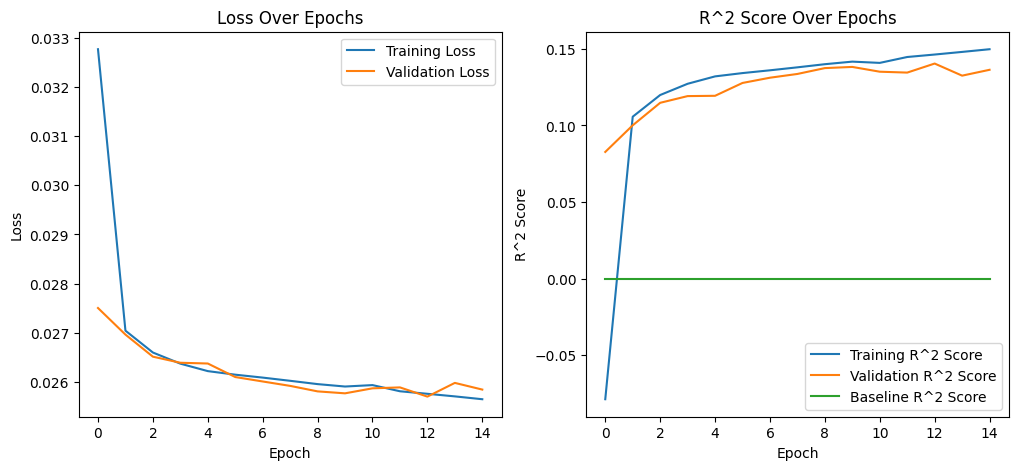

<Figure size 640x480 with 0 Axes>

In [137]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs, batchesPerInfo=10):
    train_losses = []
    train_r2 = []
    valid_losses = []
    valid_r2 = []


    model.train()
    model = model.to(device)

    try:
        for epoch in range(epochs):
            # Training
            epoch_loss = 0.0
            epoch_targets = []
            epoch_predictions = []

            batch_loss = 0.0
            batch_targets = []
            batch_predictions = []

            number_of_batches = len(train_loader)

            for i, data in enumerate(train_loader):
                x_id, x_img, x_aux, targets = data 
                x_id = x_id.to(device)
                x_img = x_img.to(device)
                x_aux = x_aux.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                predictions = model(x_img, x_aux)
                loss = criterion(predictions, targets)
                loss.backward()
                optimizer.step()

                if (i + 1) % batchesPerInfo == 0:
                    batch_r2 = r2_score(batch_targets, batch_predictions)
                    print(f'\tTBatch {i + 1}/{number_of_batches}, Loss: {batch_loss/batchesPerInfo:.4f}, R2 Score: {batch_r2:.2f}%')

                    batch_loss = 0.0
                    batch_targets = []
                    batch_predictions = []

                epoch_loss += loss.item() * x_id.size(0)
                batch_loss += loss.item() * x_id.size(0)
                epoch_targets.extend(targets.cpu().numpy())
                batch_targets.extend(targets.cpu().numpy())
                epoch_predictions.extend(predictions.squeeze().cpu().detach().numpy())
                batch_predictions.extend(predictions.squeeze().cpu().detach().numpy())

            epoch_loss = epoch_loss / len(train_loader.dataset)
            epoch_r2 = r2_score(epoch_targets, epoch_predictions)
            print(f'TEpoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, R2 Score: {epoch_r2:.2f}%')

            train_losses.append(epoch_loss)
            train_r2.append(epoch_r2)

           
            # Validation
            model.eval()

            epoch_loss = 0.0
            epoch_targets = []
            epoch_predictions = []

            batch_loss = 0.0
            batch_targets = []
            batch_predictions = []

            number_of_batches = len(valid_loader)


            with torch.no_grad():
                for i, data in enumerate(valid_loader):
                    x_id, x_img, x_aux, targets = data 
                    x_id = x_id.to(device)
                    x_img = x_img.to(device)
                    x_aux = x_aux.to(device)
                    targets = targets.to(device)

                    predictions = model(x_img, x_aux)
                    loss = criterion(predictions, targets)

                    if (i + 1) % batchesPerInfo == 0:
                        batch_r2 = r2_score(batch_targets, batch_predictions)
                        print(f'\tVBatch {i + 1}/{number_of_batches}, Loss: {batch_loss/batchesPerInfo:.4f}, R2 Score: {batch_r2:.2f}%')

                        batch_loss = 0.0
                        batch_targets = []
                        batch_predictions = []

                    epoch_loss += loss.item() * x_id.size(0)
                    batch_loss += loss.item() * x_id.size(0)
                    epoch_targets.extend(targets.cpu().numpy())
                    batch_targets.extend(targets.cpu().numpy())
                    epoch_predictions.extend(predictions.squeeze().cpu().detach().numpy())
                    batch_predictions.extend(predictions.squeeze().cpu().detach().numpy())

            epoch_loss = epoch_loss / len(valid_loader.dataset)
            epoch_r2 = r2_score(epoch_targets, epoch_predictions)
            print(f'VEpoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, R2 Score: {epoch_r2:.2f}%')
            valid_losses.append(epoch_loss)
            valid_r2.append(epoch_r2)



    except KeyboardInterrupt:
        print("Interrupted!") 


   # Plotting the Loss and R^2 Score
    plt.figure(figsize=(12, 5))

    # Plot training and test loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot R^2 score
    plt.subplot(1, 2, 2)
    plt.plot(train_r2, label='Training R^2 Score')
    plt.plot(valid_r2, label='Validation R^2 Score')
    plt.plot(np.zeros_like(valid_r2), label='Baseline R^2 Score')
    plt.xlabel('Epoch')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Score Over Epochs')
    plt.legend()

    plt.show() 

def main():
    model = PlantModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train(model, criterion, optimizer, train_loader, valid_loader, epochs=15, batchesPerInfo=500)
    torch.save(model.state_dict(), MODEL_PATH)
    plt.savefig(FIG_PATH)


main()

In [225]:
import csv
auxScaler = joblib.load(AUXSCALER_PATH)
labelScaler = joblib.load(LABELSCALER_PATH)

timageIds, tauxData, tlabels = preprocessData(TEST_AUX_PATH, False)
tlabels = np.zeros((tauxData.shape[0], LABELS_CATEGORIES))
tauxData = auxScaler.transform(tauxData)
test_loader = DataLoader(PlantDataset(timageIds, tauxData, tlabels, testImgIdMap, test_image_transform), batch_size=BATCH_SIZE, shuffle=False)

# Predict dataset
model_dict = torch.load(MODEL_PATH)
model = PlantModel()
model.load_state_dict(model_dict)

with open(SUBMISSION_PATH, "w") as file:
    columns=['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112']
    csvwriter = csv.writer(file)
    csvwriter.writerow(columns)
    
    model.eval()
    with torch.no_grad():
        for xid, img, aux, labels in test_loader:
            predictions = model(img, aux)
            predictions = predictions.numpy()
            predictions = labelScaler.inverse_transform(predictions)

            data = []
            for i,p  in zip(xid, predictions):
                data.append([i.item()] + list(p))
            csvwriter.writerows(data)

In [209]:
[1,2,3] + [4,5,6]

[1, 2, 3, 4, 5, 6]